In [4]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import imblearn
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import set_config
import os

In [5]:
path = os.environ.get('PROJECT_PATH', '.')

## Data Preparation

In [2]:
pd.set_option('display.max_columns', None)

In [110]:
set_config(display="diagram")

In [6]:
path_hit = f'{path}/data/train/ga_hits.csv'
path_ses = f'{path}/data/train/ga_sessions.csv'

df_hit = pd.read_csv(path_hit, low_memory=False)
df_ses = pd.read_csv(path_ses, low_memory=False)

загружаю данные и настраиваю вывод датафрейма в полном объеме для удобства анализа данных

In [112]:
city.head()

rank       Name     Country  Population      Prev  Growth
0     1      Tokyo       Japan    37274000  37339804 -0.0018
1     2      Delhi       India    32065760  31181376  0.0284
2     3   Shanghai       China    28516904  27795702  0.0259
3     4      Dhaka  Bangladesh    22478116  21741090  0.0339
4     5  Sao Paulo      Brazil    22429800  22237472  0.0086

In [ ]:
pandas_profiling.ProfileReport(df_hit)

In [118]:
pandas_profiling.ProfileReport(df_ses)

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

данная библиотека подготовила для меня полный отчет по данным

In [4]:
def merge_two_df(df: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df_all = df.merge(df2[['event_action', 'session_id']], on='session_id', how='outer')
    return df_all

In [120]:
df_all = merge_two_df(df_ses, df_hit)

KeyboardInterrupt: 

соединяю два датафрейма по айди сессии

### Data cleaning

In [5]:
def filter_df_f(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.loc[df['utm_source'].notna()]
    df_new = df_new.loc[df_new['client_id'].notna()]
    return df_new

фильтрую данные по незначительным пропускам в двух колонках

In [78]:
df_all = filter_df_f(df_all)

In [7]:
def filter_df_t(df: pd.DataFrame) -> pd.DataFrame:
    df = df.loc[df['CR'].notna()]
    return df

на всякий случай фильтруем по целевой переменной, на случай если были не заполненны какие-то строки 

In [8]:
def drop_dublicates(df: pd.DataFrame) -> pd.DataFrame:
    mask = df.duplicated(subset=['session_id', 'client_id', 'CR'])
    df_new = df.loc[~mask]
    return df_new

удаляем все дубликаты оставляя только уникальные айди клиентов

### Data engineering

In [79]:
mask = ['sub_car_claim_click',
            'sub_car_claim_submit_click',
            'sub_open_dialog_click',
            'sub_custom_question_submit_click',
            'sub_call_number_click',
            'sub_callback_submit_click',
            'sub_submit_success',
            'sub_car_request_submit_click']
df_all['CR'] = df_all['event_action'].isin(mask).astype(int)

In [113]:
df_new = filter_df_t(df_all)

In [114]:
df_new = drop_dublicates(df_new)

In [9]:
def create_feature_sc(df: pd.DataFrame) -> pd.DataFrame:

    def measure_device_screen(b):

        row = b['device_screen_resolution'].split('x')
        try:
            f, s = int(row[0]), int(row[1])
        except ValueError:
            f, s = 414, 896

        if f * s > 1650000:
            return 'high'
        elif 1650000 > f * s > 900000:
            return 'medium'
        else:
            return 'low'

    df['screen_category'] = df.apply(measure_device_screen, axis=1)
    return df

здесь создается новая фича, на основе разрешения экрана

In [10]:
def create_date(df: pd.DataFrame) -> pd.DataFrame:
    df['visit_date'] = pd.to_datetime(df['visit_date'], format="%Y/%m/%d")
    df['Year'] = df['visit_date'].dt.strftime('%Y')
    df['Month'] = df['visit_date'].dt.strftime('%m')
    df['Day'] = df['visit_date'].dt.strftime('%d')
    return df

добавляем в датафрейм даты, когда были соверешены действия

In [11]:
def visit_time(df: pd.DataFrame) -> pd.DataFrame:
    df['visit_time'] = pd.to_datetime(df['visit_time'], format="%H:%M:%S")
    
    def times_of_day(df):
        t = df['visit_time'].hour
        if t > 18:
            return 'Evening'
        elif 18 > t > 12:
            return 'afternoon'
        elif 12 > t > 6:
            return 'morning '
        else:
            return 'Night'
    df['times_of_day'] = df.apply(times_of_day, axis=1)
    return df

создаем новую фичу на основе времени, когда было совершено действие

In [72]:
def city_category(df: pd.DataFrame) -> pd.DataFrame:
    city = pd.read_csv(f'{path}/data/city/csvData.csv')
    huge_cities = city.query('Population >= 5000000')['Name'].tolist()
    big_cities = city.query('5000000 > Population >= 1000000')['Name'].tolist()
    medium_cities = city.query('1000000 > Population >= 500000')['Name'].tolist()

    def filtera(df):
        c =  df['geo_city']
        if c in huge_cities:
            return "huge city"
        elif c in big_cities:
            return "big city"
        elif c in medium_cities:
            return "medium city"
        else:
            return "small city"
    df['city_category'] = df.apply(filtera, axis=1)
    return df

дополняем датафрейм категориями городов из списка самых крупных за 2022 год

### Feature selection

In [12]:
def drop_column(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = [
        'utm_keyword',
        'device_os',
        'device_model',
        'session_id',
        'client_id',
        'visit_date',
        'visit_number',
        'device_screen_resolution',
        'event_action',
        'visit_time']
    return df.drop(columns_to_drop, axis=1)

удаляем все ненужные столбцы

### Data transformation

In [80]:
numerical_features = make_column_selector(dtype_include=['int64', 'float64'])
categorical_features = make_column_selector(dtype_include=object)

In [81]:
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('min_scaler', MinMaxScaler())])

к дискретным переменным применяем две функции:
* 1) заполняет пропуски медианой 
* 2) стандартизирует данные по минимуму и максимуму

In [82]:
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

категориальные переменные заполняются модой

In [83]:
column_transformer = ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])

In [84]:
preprocessor_first = Pipeline(steps=[
        ('create_date', FunctionTransformer(create_date)),
        ('create_visit_time', FunctionTransformer(visit_time)),
        ('create_sc', FunctionTransformer(create_feature_sc)),
        ('create_city_category', FunctionTransformer(city_category)),
        ('drop_column', FunctionTransformer(drop_column)),
        ('column_transformer', column_transformer)])

In [115]:
y = df_new.CR
y = y.astype(int)

сразу же достаем нашу целевую переменную и на всякий случай приводим ее к целому числу, дабы избежать ошибок

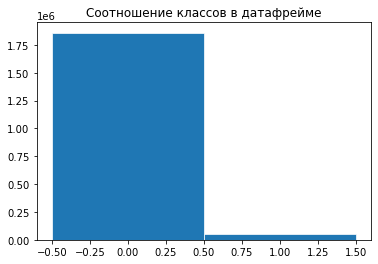

In [117]:
count_classes = df_new['CR'].value_counts()
fig, ax = plt.subplots()
ax.bar(x=count_classes.index, height=count_classes.values, width=1, edgecolor="white", linewidth=0.7)
ax.set_title('Соотношение классов в датафрейме')
plt.show()

In [88]:
df_new = df_new.drop('CR', axis=1)

In [89]:
X = preprocessor_first.fit_transform(df_new)

In [111]:
preprocessor_first

Pipeline(steps=[('create_date',
                 FunctionTransformer(func=<function create_date at 0x000001C096B30550>)),
                ('create_visit_time',
                 FunctionTransformer(func=<function visit_time at 0x000001C096B30E50>)),
                ('create_sc',
                 FunctionTransformer(func=<function create_feature_sc at 0x000001C0C41E38B0>)),
                ('create_city_category',
                 FunctionTransformer(func=<function city_category at...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('min_scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C1286242B0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C1286245B0>)]))])

## Modeling

### model selection

In [31]:
xgb_cl  = XGBClassifier(use_label_encoder=False,
                        objective='binary:logistic',
                        n_jobs=-1,
                        learning_rate=0.1,
                        max_depth=6,
                        scale_pos_weight=40,
                        subsample=0.7,
                        tree_method='exact', gamma=3,
                        reg_alpha=15, reg_lambda=15,
                        n_estimators=100,
                        max_delta_step=10,
                        num_parallel_tree=3,
                        min_child_weight=1
                       )

In [30]:
clf = BalancedRandomForestClassifier(max_depth=100, random_state=42,  n_jobs=-1,
                                    n_estimators=250, max_features='sqrt', min_samples_split=10,
                                     min_samples_leaf=2, criterion='entropy', oob_score='True',
                                     replacement='False', class_weight={0:1, 1: 1.15})


In [92]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [93]:
score = cross_val_score(xgb_cl, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')

In [94]:
score2 = cross_val_score(clf, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')

In [95]:
print(f'XGBClassifier: , roc_auc: {score.mean():.4f}')
print(f'BalancedRandomForestClassifier: , roc_auc: {score2.mean():.4f}')

XGBClassifier: , roc_auc: 0.6931
BalancedRandomForestClassifier: , roc_auc: 0.6873


определив, что XGBClassifier, в целом на тренировочных данных лучше справляется на кросс валидации, необходимо проверить модель на тестовых данных

In [100]:
xgb_cl.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=10, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=3, predictor='auto', random_state=0,
              reg_alpha=15, reg_lambda=15, ...)

In [101]:
import dill
with open("f'{path}/data/test/ds_final_test_dataset.pkl", 'rb') as f:
    test = dill.load(f)

импортируем тестовые данные

In [102]:
mask = ['sub_car_claim_click',
            'sub_car_claim_submit_click',
            'sub_open_dialog_click',
            'sub_custom_question_submit_click',
            'sub_call_number_click',
            'sub_callback_submit_click',
            'sub_submit_success',
            'sub_car_request_submit_click']
test['CR'] = test['event_action'].isin(mask).astype(int)

добавляем целевую переменную

In [103]:
test_new = drop_dublicates(test)

In [104]:
y_t = test_new.CR
y_t = y_t.astype(int)
test_new = test_new.drop('CR', axis=1)

In [105]:
X_t = preprocessor_first.transform(test_new)

разделяем данные и трансформируем на раннее обученном пайплайне

### Results

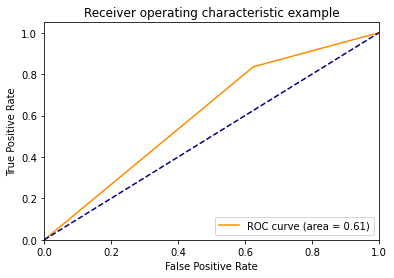

In [106]:
score3 = xgb_cl.predict(X_t)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_t, score3)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [107]:
confusion_matrix(y_t, score3)

array([[ 79599, 132649],
       [   599,   3048]], dtype=int64)